In [1]:
import time
import pandas as pd
from kid_readout.analysis import archive
from equipment.vdi.zbd import ZBD
from equipment.srs.lockin import SR830
plt.rcParams['font.size'] = 11

/home/local/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


updated file list


In [2]:
def zbd_peak_voltage(lockin_rms_voltage):
    return 2**(-1/2) * np.pi * lockin_rms_voltage

def lockin_rms_voltage(zbd_peak_voltage):
    return 2**(1/2) / np.pi * zbd_peak_voltage

def zbd_power(lockin_rms_voltage, optical_frequency=None):
    if optical_frequency is None:
        return zbd_peak_voltage(lockin_rms_voltage) / 2200
    else:
        return zbd_peak_voltage(lockin_rms_voltage) / ZBD().responsivity(optical_frequency)

def acquire(df, lockin, mickey, minnie):
    lockin.auto_gain()
    time_constant = lockin.time_constant_integer_to_seconds[lockin.time_constant]
    time.sleep(5 * time_constant)
    return df.append({'time': time.time(),
                      'mickey': mickey,
                      'minnie': minnie,
                      'R': lockin.R,
                      'time_constant': time_constant},
             ignore_index=True)
    return df

In [3]:
lockin = SR830('/dev/ttyUSB2')
zbd = ZBD()

In [4]:
broadband = archive.load_archive('/data/readout/archive/2015-05-12_mmw_noise_broadband.npy')
broadband.zbd_power.max()

3.7687114014880809e-05

In [5]:
broadband.zbd_power.min()

2.0691350543472895e-10

# Data

Use the default responsivity of 2200 V / W. These settings more or less bracket the nominal linear region of 1 to 10 $\mu$W:

In [6]:
lockin.auto_gain()

In [7]:
lockin.time_constant = 9

In [8]:
1e6 * zbd_power(lockin.R, optical_frequency=None)

7.835710688805449

All previous data was taken with the final setting approached from above. However, approaching from below seems to create less scatter in the power readings at the same number of turns. If the structure in the waveguide is hanging from the micrometer, pulling it up may be more reliable than pushing it down. In any case, all the data here is taken with the approach in the direction of increasing micrometer reading, which would correspond to loosening a screw.

To avoid using fractional numbers, let's try using ticks instead with 1 turn equal to 25 ticks. (The micrometers seem to move 0.1 inches per turn, or 1 mil per tick.)

Use 120, 120 ticks (4.8, 4.8 turns) as the witness setting.

In [9]:
witness = 120

In [10]:
df_filename = '/home/flanigan/equipment/vdi/calibration_broadband.npy'

In [11]:
#df = pd.DataFrame(columns=('time', 'mickey', 'minnie', 'R', 'time_constant'))
df = pd.DataFrame().from_records(np.load(df_filename), index='index')

Take a point and plot the existing data

In [15]:
#df = df.drop(df.index[-1:])

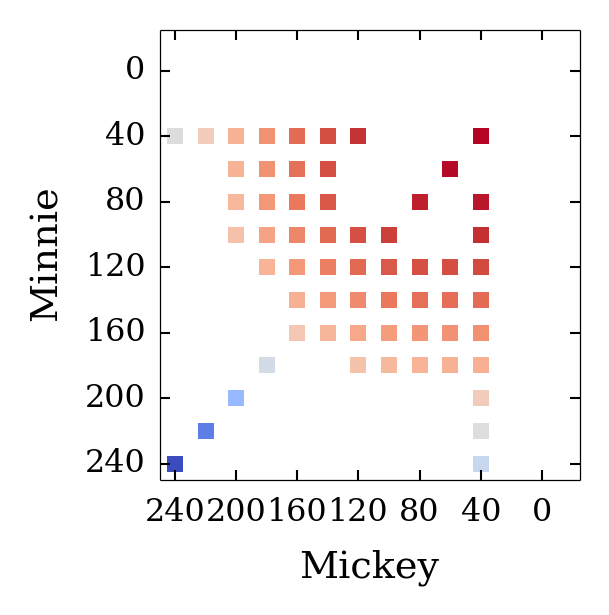

In [21]:
mickey = 120
minnie = 120
df = acquire(df, lockin, mickey, minnie)
np.save(df_filename, df.to_records())

fig, ax = plt.subplots(figsize=(2, 2))
norm = matplotlib.colors.LogNorm
mappable = plt.cm.ScalarMappable(norm(min(df.R), max(df.R)), cmap=plt.cm.coolwarm)
mappable.set_array(np.array(df.R))
for n, row in df.iterrows():
    ax.plot(row.mickey, row.minnie, color=mappable.to_rgba(row.R),
            marker='s', markersize=4, markeredgecolor='none')
ax.set_xlim(250, -25)
ax.set_xticks(range(240, -20, -40))
ax.set_ylim(250, -25)
ax.set_yticks(range(240, -20, -40))
ax.set_xlabel('Mickey')
ax.set_ylabel('Minnie');

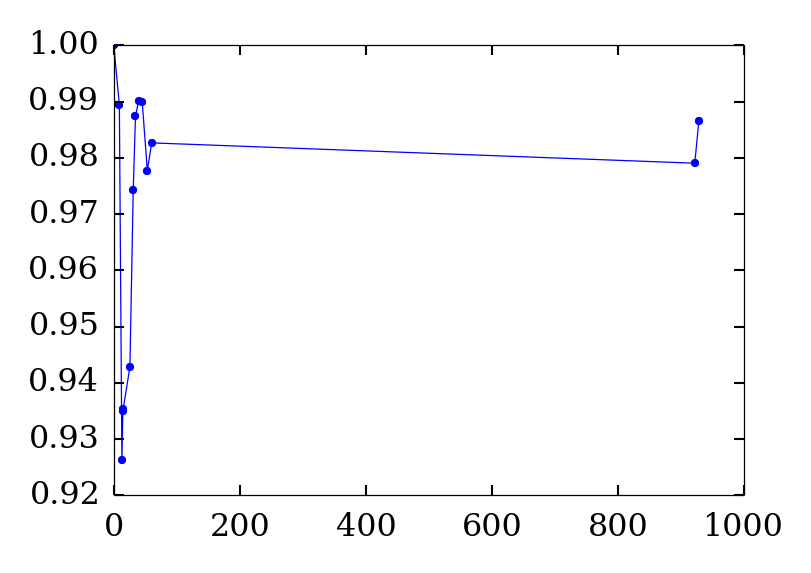

In [22]:
mask = (df.mickey==witness) & (df.minnie==witness)
plt.plot((df[mask].time - df.time.min()) / 60, df[mask].R / df[mask].R.iloc[0], '.-')